# US CPI, Fed Funds Effective Rate, Market Yield on US Treasury Securities at 10-Year, and Comparison of US Treasury Yield Curve with Annual Inflation Expectations
This notebook juxtaposes the evolution of US seasonally adjusted CPI with Fed Funds Effective Rate and 10 year US Treasury yield. Most of the time the Fed Funds rate and 10 year treasury yields have been slightly above the CPI, yet this is not the case from 2021 anymore.

It then looks at the the relationship between riskfree rates (e.g. 10-year Treasury rates) and CPI + real GDP growth rates. CPI + GDP growth rates is known as _the intrinsic riskfree rate_. In theory the 10-year Treasury rate should be similar to the intrinsic riskfree rate. This notebook looks at how this played out in practice since the 70's.

The notebook also looks forwards by comparing the present US Treasury Yield Curve with US Annual Inflation Expectations based on 1) Expected inlfation from [Federal Reserve Bank of Cleveland](https://www.clevelandfed.org/indicators-and-data/inflation-expectations) and 2) Breakeven inflation rates as priced by Financial Markets. The breakeven inflation rate represents a measure of expected inflation derived from N-Year Treasury Constant Maturity Securities and N-Year Treasury Inflation-Indexed Constant Maturity Securities.

In the last section of this notebook I look at correlations between changes in the Fed Funds Rates and CPI. A corresponding analysis of correlations between the broad money supply M2 and CPI can be found in [this jupyter notebook](./M2_PCE_and_CPI.ipynb).

Whereever possible I make use of data series with monthly frequencies provided by [FRED](https://fred.stlouisfed.org/). In cases where only daily freqencies are available, I downsample to month end.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves

In [3]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

### Get Consumer Price Index for All Urban Consumers, Fed Funds Effective Rate, 10 Year US Treasury Yield, and Real GDP
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency, from 1947)
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency, from 1953)

There's a relationship between the riskless rate as represented by Treasury yields on the one hand and real GDP growth and inflation rates on the other hand. At the end of this section I look at real GDP developments in conjunction with CPI, for which I make use of the following additional dataseries from [FRED](https://fred.stlouisfed.org/):
* `GDPC1` &mdash; Real Gross Domestic Product, Seasonally Adjusted (quarterly frequency)

In [4]:
fred_cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS', 'GS10', 'GS3M', 'FII10'], start=report_start, end=report_end)
real_gdp = web.get_data_fred('GDPC1', start=report_start, end=report_end)

In [5]:
# Since CPIAUCSL is indexed to 1982-1984=100, we need to convert it to annual percentage changes
fred_cpi_ffr.update(fred_cpi_ffr.CPIAUCSL.pct_change(12, fill_method='bfill')*100)

# For real GDP I translate the growth over one quarter into annual rate to be consistent with
# how the BEA does it.
real_gdp_quarterly = ((real_gdp/real_gdp.shift(1)).pow(4)-1)

# If instead you want to calculate GDP growth over the whole year, the correct way to do that is
real_gdp = real_gdp.rolling(4).mean().pct_change(4, fill_method='bfill').loc['1970':]

fred_cpi_ffr = fred_cpi_ffr.loc['1970':]
fred_cpi_ffr.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI', 'FEDFUNDS': 'Federal Funds Effective Rate',
             'GS10': '10y Treasury Yield', 'GS3M': '3m Treasury Yield',
             'FII10': '10y TIPS Yield'},
    inplace=True)
real_gdp.rename(columns={'GDPC1': 'Real GDP'}, inplace=True)
real_gdp['Real GDP over quarter at annual rate'] = real_gdp_quarterly
fred_cpi_ffr /= 100.
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
fred_cpi_ffr.loc['2020':]

,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield,3m Treasury Yield,10y TIPS Yield
DATE,,,,,
2020-01-01,2.5123%,1.5500%,1.7600%,1.5500%,0.0400%
2020-02-01,2.3397%,1.5800%,1.5000%,1.5400%,-0.1100%
2020-03-01,1.5231%,0.6500%,0.8700%,0.3000%,-0.1200%
2020-04-01,0.3499%,0.0500%,0.6600%,0.1400%,-0.4500%
2020-05-01,0.2162%,0.0500%,0.6700%,0.1300%,-0.4400%
...,...,...,...,...,...
2023-09-01,3.6941%,5.3300%,4.3800%,5.5600%,2.0400%
2023-10-01,3.2458%,5.3300%,4.8000%,5.6000%,2.4100%
2023-11-01,3.1395%,5.3300%,4.5000%,5.5200%,2.2000%


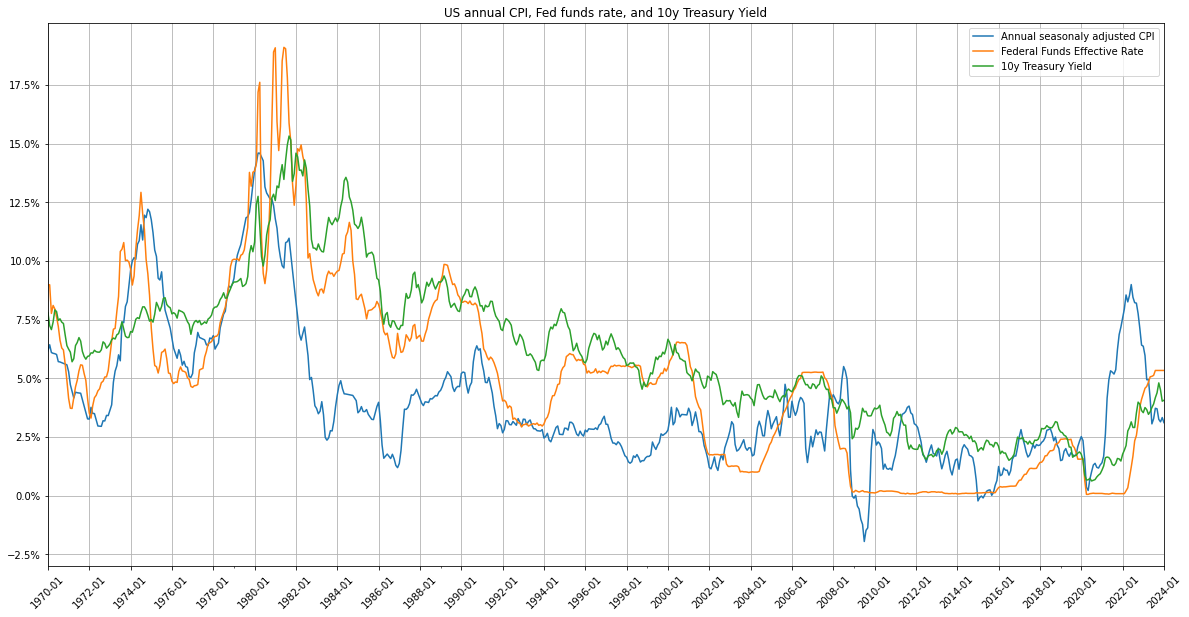

In [6]:
ax = fred_cpi_ffr.iloc[:,:-2].plot(figsize=(20,10), grid=True, title='US annual CPI, Fed funds rate, and 10y Treasury Yield',
                       xticks=fred_cpi_ffr.index[::24], xlabel='', rot=45, yticks=np.arange(-.025, .2, 0.025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, fred_cpi_ffr.index[::24])))

#### CPI inflation based on monthly and quarterly changes
In the previous part of this notebook I looked at CPI based on changes compared to 12 months ago. This is the standard way of determining annual percentage cahnges. Below I look at monthly changes in CPI and then translate them into annual percentage changes using the following simple formula for translating monthly wage changes into annual percentage changes:

$$\left(\left({\text{level of month n+1} \over \text{level of month n}}\right)^{12}-1\right)\times 100\% $$

And then the same for translating quarterly changes into annual rates:

$$\left(\left({\text{level of month n+1} \over \text{level of month n-2}}\right)^4-1\right)\times 100\% $$

In [7]:
from_date = date(2020, 1, 1)
cpi = web.get_data_fred('CPIAUCSL', start=report_start, end=report_end)
cpi_monthly = cpi.pct_change(fill_method='bfill').loc[from_date:, 'CPIAUCSL'].rename('CPI Change over Prev Month')
cpi_annual = ((cpi/cpi.shift(1)).pow(12)-1).loc[from_date:, 'CPIAUCSL'].rename('CPI Change over Prev Month at Annual Rate')
cpi_quarterly = ((cpi/cpi.shift(3)).pow(4)-1).loc[from_date:, 'CPIAUCSL'].rename('CPI Change over Prev 3 Months at Annual Rate')

In [8]:
cpi_df = pd.concat([fred_cpi_ffr.loc[from_date:].iloc[:,0], cpi_quarterly, cpi_annual], axis=1)
cpi_df

,Annual seasonaly adjusted CPI,CPI Change over Prev 3 Months at Annual Rate,CPI Change over Prev Month at Annual Rate
DATE,,,
2020-01-01,2.5123%,2.7516%,1.2881%
2020-02-01,2.3397%,2.1373%,1.5873%
2020-03-01,1.5231%,-0.7403%,-4.9569%
2020-04-01,0.3499%,-4.2263%,-9.0132%
2020-05-01,0.2162%,-5.1407%,-1.2947%
...,...,...,...
2023-09-01,3.6941%,4.3929%,4.4014%
2023-10-01,3.2458%,3.8667%,0.9531%
2023-11-01,3.1395%,2.4215%,1.9408%


In [9]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'

In [10]:
cpi_df = cpi_df.loc['2020':, cpi_df.columns[0:2]]
cpi_df.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=cpi_df.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Annual seasonaly adjusted CPI,CPI Change over Prev 3 Months at Annual Rate
DATE,,
2022-08,8.22%,5.39%
2022-09,8.20%,1.84%
2022-10,7.75%,3.97%
2022-11,7.12%,4.74%
2022-12,6.41%,3.38%
2023-01,6.36%,3.39%
2023-02,5.97%,3.89%
2023-03,4.94%,3.98%
2023-04,4.94%,3.61%


### Analysis of relationship between GDP growth and riskfree interest rates
For GDP I present both the growth over the last 4 quarters as well as growth over one quarter, both expressed as annual percentage rates.

In [11]:
# real_gdp.loc['2020':]
real_gdp.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=real_gdp.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Real GDP,Real GDP over quarter at annual rate
DATE,,
2019-07,2.20%,4.61%
2019-10,2.47%,2.59%
2020-01,2.31%,-5.34%
2020-04,-0.14%,-28.02%
2020-07,-1.17%,34.84%
2020-10,-2.21%,4.21%
2021-01,-2.12%,5.24%
2021-04,2.54%,6.22%
2021-07,4.12%,3.30%


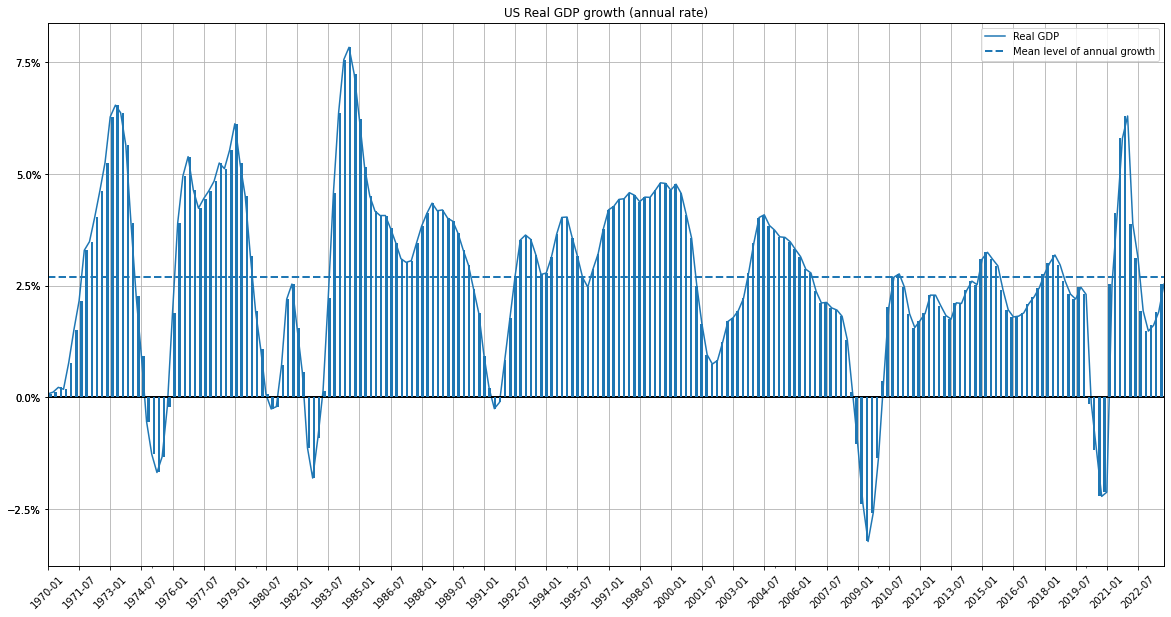

In [12]:
ax = real_gdp.iloc[:,0].plot(figsize=(20,10), grid=True, title='US Real GDP growth (annual rate)',
                   xticks=real_gdp.index[::6], xlabel='', rot=45, yticks=np.arange(-.05, .125, 0.025))
ax.axhline(y=0, lw=2, c='k')
ax.axhline(y=real_gdp.iloc[:,0].mean(), lw=2, ls='--', c='#1f77b4', label='Mean level of annual growth')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2 = ax.twiny()
real_gdp.iloc[:,0].plot.bar(ax=ax2, xlabel='', legend=False)
ax2.xaxis.set_major_locator(mtick.NullLocator())
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_gdp.index[::6])))

In [13]:
print(f'Mean level of annual GDP growth since {real_gdp.index[0]:%Y-%m-%d}: {real_gdp.iloc[:,0].mean():.2%}')

Mean level of annual GDP growth since 1970-01-01: 2.70%


In [14]:
df = pd.concat([real_gdp.iloc[:,0], fred_cpi_ffr.resample('qs').mean()], axis=1)
df.loc['1981':]

,Real GDP,Annual seasonaly adjusted CPI,Federal Funds Effective Rate,10y Treasury Yield,3m Treasury Yield,10y TIPS Yield
DATE,,,,,,
1981-01-01,-0.2058%,11.2663%,16.5700%,12.9600%,NaN,NaN
1981-04-01,0.7188%,9.8750%,17.7800%,13.7500%,NaN,NaN
1981-07-01,2.2001%,10.8525%,17.5767%,14.8467%,15.6100%,NaN
1981-10-01,2.5377%,9.5877%,13.5867%,14.0867%,12.3000%,NaN
1982-01-01,1.5639%,7.5851%,14.2267%,14.2933%,13.5033%,NaN
...,...,...,...,...,...,...
2023-01-01,1.4847%,5.7542%,4.5167%,3.6467%,4.7800%,1.3533%
2023-04-01,1.6146%,4.0383%,4.9900%,3.5933%,5.2667%,1.3667%
2023-07-01,1.9193%,3.5615%,5.2600%,4.1500%,5.5367%,1.8233%


#### Visualizing the relationship between Treasury yields and the intrinsic riskfree rate (real GDP growth + inflation rates)
How high should a riskless rates be? One popular theory is that it should be close to the sum of the expected annual rate of GDP growth and inflation. In other words real riskfree rates, which for the US are best deined by yields on Treasury inflation protected securities (TIPS) should be in line with expected GDP growth.

In this section of the notebook I look at how this has been developing in the US.

In [15]:
#df = df.loc['1997':,:]

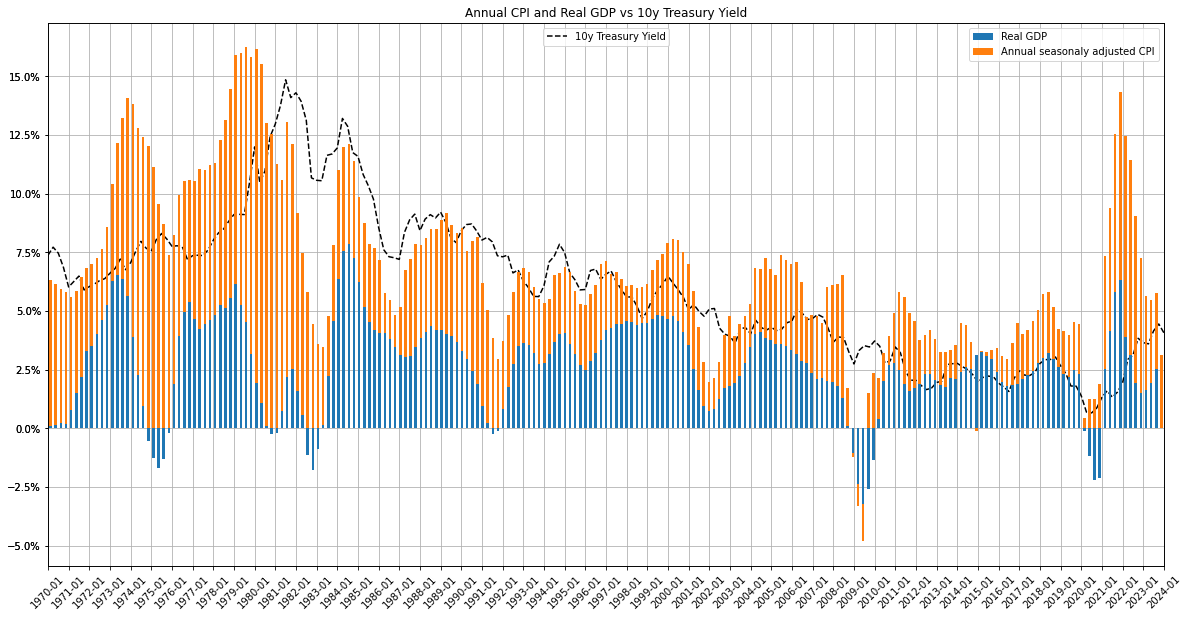

In [16]:
ax = df.iloc[:, -3].plot(figsize=(20,10), grid=True,
                         title='Annual CPI and Real GDP vs 10y Treasury Yield', 
                         xticks=df.index[::4], yticks=np.arange(-.075, .2, 0.025),
                         xlabel='', rot=45, linestyle='--', color='k')
ax2 = ax.twiny()
df.iloc[:,[0,1]].plot.bar(ax=ax2, xlabel='', stacked=True)
#df.iloc[:, -1].plot(ax=ax, grid=True, xticks=df.index[::4], xlabel='', rot=45, linestyle='dotted', color='k')
ax.legend(loc='upper center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::4])))

In [17]:
df = df.loc[:real_gdp.last_valid_index()] # Truncate based on last valid GDP value
print('Gap between intrinsic (GDP+CPI) and actual (10y Treasury) riskfree rates in quarter starting in {:%Y-%m}: {:.2%}\n'
      'Compared with: {:.2%} one quarter earlier\n'.format(df.index[-1].date(),
    df.iloc[-1,0] + df.iloc[-1,1] - df.iloc[-1,3], df.iloc[-2,0] + df.iloc[-2,1] - df.iloc[-2,3]))

print('Gap between intrinsic (GDP+CPI) and actual (3m Treasury) riskfree rates in quarter starting in {:%Y-%m}: {:.2%}\n'
      'Compared with: {:.2%} one quarter earlier\n'.format(df.index[-1].date(),
    df.iloc[-1,0] + df.iloc[-1,1] - df.iloc[-1,4], df.iloc[-2,0] + df.iloc[-2,1] - df.iloc[-2,4]))

from_dt = date(1997, 1, 1)
#from_dt = df.index[0]
means = df.loc[from_dt:].mean()

print('Average gap between intrinsic (GDP+CPI) and actual (10y Treasury) riskfree rates starting from {:%Y-%m}: {:.2%}'
      .format(from_dt, means.iloc[0] + means.iloc[1] - means.iloc[3]))
print('Average gap between intrinsic (GDP+CPI) and actual (3m Treasury) riskfree rates starting from {:%Y-%m}: {:.2%}'
      .format(from_dt, means.iloc[0] + means.iloc[1] - means.iloc[4]))

Gap between intrinsic (GDP+CPI) and actual (10y Treasury) riskfree rates in quarter starting in 2023-10: 1.33%
Compared with: 1.33% one quarter earlier

Gap between intrinsic (GDP+CPI) and actual (3m Treasury) riskfree rates in quarter starting in 2023-10: 0.25%
Compared with: -0.06% one quarter earlier

Average gap between intrinsic (GDP+CPI) and actual (10y Treasury) riskfree rates starting from 1997-01: 1.40%
Average gap between intrinsic (GDP+CPI) and actual (3m Treasury) riskfree rates starting from 1997-01: 2.85%


**Conclusion:** Even though treasury yields compensate for current and expected inflation, the current levels of riskfree rates are still below the intrinsic riskfree levels implied by GDP growth and CPI inflation.

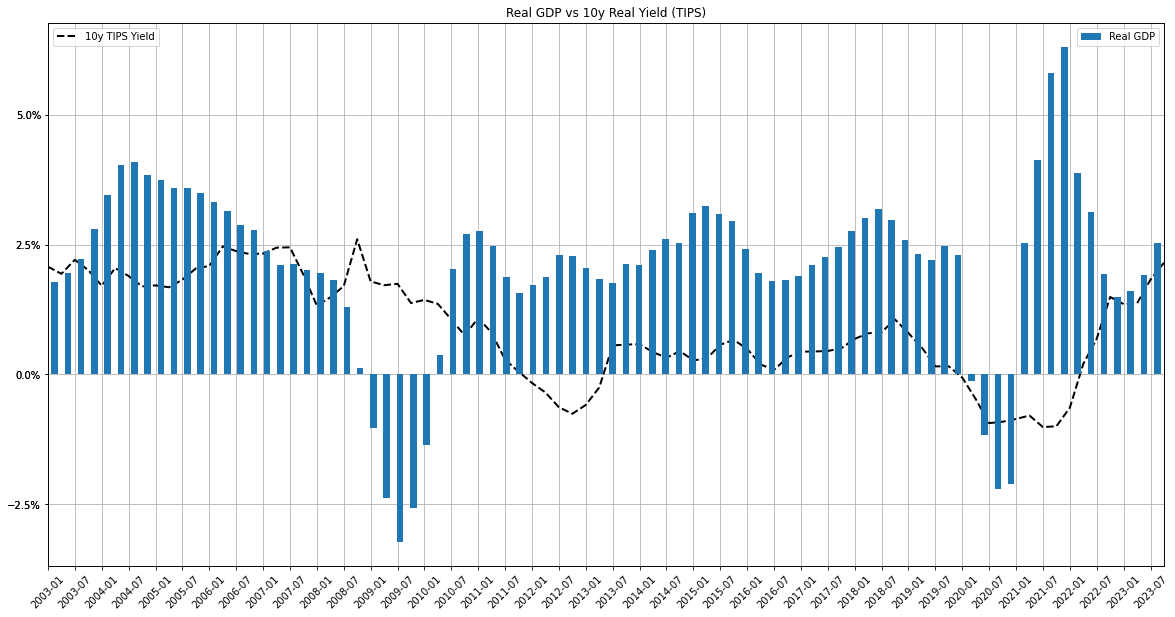

In [18]:
df_gdp_tips = df.iloc[:, [0,-1]]
df_gdp_tips = df_gdp_tips.loc[df_gdp_tips.iloc[:,-1].first_valid_index():]
ax = df_gdp_tips.iloc[:, -1].plot(figsize=(20,10), grid=True,
                         title='Real GDP vs 10y Real Yield (TIPS)', linewidth=2,
                         xticks=df_gdp_tips.index[::2], yticks=np.arange(-.075, .2, 0.025),
                         xlabel='', rot=45, linestyle='--', color='k')
ax2 = ax.twiny()
df_gdp_tips.iloc[:,0].plot.bar(ax=ax2, xlabel='', stacked=True)
ax.legend(loc='upper left')#loc='upper right')
ax2.legend(loc='upper right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df_gdp_tips.index[::2])))

In [19]:
df_gdp_tips = df_gdp_tips.loc[:real_gdp.last_valid_index()]
print('Gap between intrinsic GDP and actual 10y Real Riskfree Rate in quarter starting in {:%Y-%m}: {:.2%}\n'
      'Compared with: {:.2%} one quarter earlier\n'.format(df_gdp_tips.index[-1].date(),
    df_gdp_tips.iloc[-1,0] - df.iloc[-1,-1], df.iloc[-2,0] - df.iloc[-2,-1]))

Gap between intrinsic GDP and actual 10y Real Riskfree Rate in quarter starting in 2023-10: 0.39%
Compared with: 0.10% one quarter earlier



**Conclusion 2**: Real riskfree rates as implied by 10-year Treasury inflation protected securities, is closing in on GDP growth rate.

### Analyzing US Treasury Curve and US Annual Inflation Expectations
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `FEDFUNDS` &mdash; Federal Funds Effective Rate (monthly frequency, from 1954)
* `DGS1MO` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3MO` &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS6MO` &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `GS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS2` &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS3` &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS5` &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS7` &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `GS30` &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (monthly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency)
* `EXPINF1YR` &mdash; 1-Year Expected Inflation (monthly frequency)
* `EXPINF2YR` &mdash; 2-Year Expected Inflation (monthly frequency)
* `EXPINF3YR` &mdash; 3-Year Expected Inflation (monthly frequency)
* ...
* `EXPINF30YR` &mdash; 30-Year Expected Inflation (monthly frequency)
* `T5YIEM` &mdash; 5-Year Breakeven Inflation Rate (monthly frequency)
* `T7YIEM` &mdash; 7-Year Breakeven Inflation Rate (monthly frequency)
* `T10YIEM` &mdash; 10-Year Breakeven Inflation Rate (monthly frequency)
* `T20YIEM` &mdash; 20-Year Breakeven Inflation Rate (monthly frequency)
* `T30YIEM` &mdash; 30-Year Breakeven Inflation Rate (monthly frequency)

For calculating inflation expectations one can use either 1) breakeven inflation rates (as given by subtracting the yield on the Treasury Inflation-Protected Securities of N-Year maturity from the yield on the ordinary Treasury Bond of the same N-Year maturity) or 2) expected inflation rates (as calculated by The Federal Reserve Bank of Cleveland based on Inflation swap data, Treasury Yields, current CPI, Blue Chip forecast of CPI). In essence both approaches give an indication of what the Financial Markets expect the inflation to be on average over the N-Year perood. For inflation expectaion of maturity 0, I take the last published seasonally adjusted CPI.

The difference between breakeven inflation and expected inflation is subtle but important and given by the following formula:
> breakeven inflation = expected inflation + inflation risk premium – TIPS liquidity premium

Investors in treasuries take on inflation risk (i.e. the risk that actual inflation over the maturity of a treasury bond turns out to be higher than the expected one). A compensation for this risk is embedded in the price of treasury bonds (see _inflation risk premium_ in the above formula). Inflation protected treasuries are not as liquid as regular treasury bonds, therefore investors in TIPS require a compensation for it. This is called the _TIPS liquidity premium_. The inflation risk premium and TIPS liquidity premium are more or less the same, however sometimes they differ. Therefore expected inflation is a more accurate estiate of inflation expectations than breakeven inflation and I use it in the majority of graphs below. Please refer to [this article](https://www.federalreserve.gov/econres/notes/feds-notes/tips-from-tips-update-and-discussions-20190521.html) for more information if you are interested.

It's important to take day count conventions and compounding frequencies into account:
* Constant Maturity Treasury Seecurities (CMT) yields are provided with semiannual compounding frequencies using the actual/actual day count convention, as explained [here](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions)
* Federal Funds Effective Rate, on the other hand, is provied using the actual/360 day count convention with annual compounding.
* For Federal Reserve Bank of Cleveland expected inflation data I assume to be provided using actual/actual day count with annual compounding frequency.

In this notebook I convert all rates to actual/actual day count with annual compounding frequency, whereby obtaining Annual Percentage Yields (APY).

#### Retrieving and preparing data for US Treasury Yield Curve construction

In [20]:
report_start = date.fromisoformat('2012-01-01')

# Treasury yield curve
data = web.get_data_fred(['FEDFUNDS', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30'], report_start, report_end)
data.dropna(inplace=True)

# The following data series are only provided with daily frequences, hence we need to downsample them
# by taking their mean value over a given month and rounding to two decimal points (that's how values
# in series with monthly frequencies are calculated)
data2 = web.get_data_fred(['DGS1MO', 'DGS3MO', 'DGS6MO'], report_start, report_end)
data2 = data2.resample('MS').mean().round(2)

data = pd.concat([data, data2], axis=1).dropna()

# Rearranging columns
data = data[['FEDFUNDS', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'GS1', 'GS2', 'GS3', 'GS5', 'GS7', 'GS10', 'GS20', 'GS30']]

# Renaming to reflect quarterly frequencies in the columns that used to have monthly frequencies
data.rename(columns={'DGS1MO': 'GS1MO', 'DGS3MO': 'GS3MO', 'DGS6MO': 'GS6MO'}, inplace=True)

# Converting to decimal fractions, i.e. 1% is 0.01
data /= 100.

# Converting the Fed Funds Rate to actual/actual
leap_year_cond = data.FEDFUNDS.index.year % 4 == 0 & ((data.FEDFUNDS.index.year % 100 != 0) | (data.FEDFUNDS.index.year % 400 == 0))
data.FEDFUNDS[leap_year_cond] *= 366. / 360
data.FEDFUNDS[np.invert(leap_year_cond)] *= 365. / 360

# Converting all CMT Yields to APY
data.iloc[:, 1:] = (data.iloc[:, 1:]/2 + 1)**2 - 1

In [21]:
data

,FEDFUNDS,GS1MO,GS3MO,GS6MO,GS1,GS2,GS3,GS5,GS7,GS10,GS20,GS30
DATE,,,,,,,,,,,,
2012-01-01,0.0813%,0.0200%,0.0300%,0.0700%,0.1200%,0.2401%,0.3603%,0.8418%,1.3848%,1.9797%,2.7182%,3.0530%
2012-02-01,0.1017%,0.0600%,0.0900%,0.1200%,0.1601%,0.2802%,0.3804%,0.8317%,1.3747%,1.9797%,2.7689%,3.1342%
2012-03-01,0.1322%,0.0600%,0.0800%,0.1400%,0.1901%,0.3403%,0.5107%,1.0226%,1.5661%,2.1818%,2.9616%,3.3069%
2012-04-01,0.1423%,0.0700%,0.0800%,0.1400%,0.1801%,0.2902%,0.4305%,0.8920%,1.4351%,2.0605%,2.8399%,3.2053%
2012-05-01,0.1627%,0.0700%,0.0900%,0.1501%,0.1901%,0.2902%,0.3904%,0.7614%,1.2137%,1.8081%,2.5460%,2.9515%
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,5.4040%,5.6065%,5.6373%,5.5859%,5.5140%,5.0830%,4.7962%,4.5404%,4.5097%,4.4280%,4.7041%,4.5200%
2023-10-01,5.4040%,5.6476%,5.6784%,5.6476%,5.4934%,5.1343%,4.9498%,4.8269%,4.8781%,4.8576%,5.1958%,5.0113%
2023-11-01,5.4040%,5.6065%,5.5962%,5.5140%,5.3497%,4.9395%,4.6938%,4.5404%,4.5813%,4.5506%,4.8986%,4.7143%


#### Retrieving data for inflation expectaions curve construction
In contrast to the yield curve construction, no adjustments are required for compounding frequencies:

* Breakeven inflation rates are reported based on spot rates with an annual compounding frequency, as explained [here](https://home.treasury.gov/system/files/226/bri_mar2019_acc.pdf)
* The way CPI is calculated results in annual compounding with an actual/actual day count convention.

In [22]:
# Inflation expectaions as given by breakeven inflation rates
data_infl_brk_evn = web.get_data_fred(['T5YIEM', 'T7YIEM', 'T10YIEM', 'T20YIEM', 'T30YIEM'], report_start, report_end)
data_infl_brk_evn.dropna(inplace=True)

cpi = fred_cpi_ffr[['Annual seasonaly adjusted CPI']].loc['2012':]

# Expected inflation as calculated by The Federal Reserve Bank of Cleveland based on Inflation swap data,
# Treasury Yields, current CPI, Blue Chip forecast of CPI.
data_infl = web.get_data_fred(['EXPINF' + str(i) + 'YR' for i in range(1, 31)], report_start, report_end).shift(-1)

# Converting to decimal fractions, i.e. 1% is 0.01
data_infl_brk_evn /= 100.
data_infl /= 100.

# Adding CPI and The Federal Reserve Bank of Cleveland 1 Year Inflation Expectation
data_infl = pd.concat([cpi, data_infl], axis=1).dropna()
data_infl_brk_evn = pd.concat([cpi, data_infl_brk_evn], axis=1)

In [23]:
#data_infl_brk_evn.fillna(method='ffill', inplace=True)
data_infl_brk_evn

,Annual seasonaly adjusted CPI,T5YIEM,T7YIEM,T10YIEM,T20YIEM,T30YIEM
DATE,,,,,,
2012-01-01,3.0088%,1.7600%,1.9300%,2.0800%,2.1900%,2.2900%
2012-02-01,2.8982%,1.9400%,2.0600%,2.2200%,2.3000%,2.3900%
2012-03-01,2.5829%,2.0500%,2.1300%,2.3100%,2.3800%,2.4100%
2012-04-01,2.2732%,1.9500%,2.0800%,2.2600%,2.3200%,2.3900%
2012-05-01,1.7379%,1.8800%,2.0000%,2.1400%,2.0900%,2.2500%
...,...,...,...,...,...,...
2023-09-01,3.6941%,2.2500%,2.3500%,2.3400%,2.5800%,2.3400%
2023-10-01,3.2458%,2.3100%,2.3900%,2.3900%,2.6800%,2.4700%
2023-11-01,3.1395%,2.2500%,2.3100%,2.3000%,2.6100%,2.4000%


#### Constructing US Treasury Yield and Inflation expectations curves

In [24]:
date = data.index[-1].date()
date_1_mth_ago = date + relativedelta(months=-1)
date_1_year_ago = date + relativedelta(years=-1)
date_2_years_ago = date + relativedelta(years=-2)
date_5_years_ago = date + relativedelta(years=-5)
date_10_years_ago = date + relativedelta(years=-10)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# 30 datapoints for expected inflation data from The Federal Reserve Bank of Cleveland
offsets_infl = [relativedelta(years=+i) for i in range(31)]

# Unfortunately fewer curve points for US Inflation expectations
offsets_infl_brk_evn = [relativedelta(), relativedelta(years=+5), relativedelta(years=+7),
                        relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Define US Treasury yield curves
curve = curves.YieldCurve(date, offsets, data[date:date+BDay()].to_numpy()[0,:])
curve_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets,
                                    data[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:])
curve_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets,
                                     data[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets,
                                      data[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets,
                                      data[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])
curve_10_years_ago = curves.YieldCurve(date_10_years_ago, offsets,
                                       data[date_10_years_ago:date_10_years_ago+BDay()].to_numpy()[0,:])

# Define US Expected Inflation curves
curve_infl = curves.YieldCurve(date, offsets_infl, data_infl[date:date+BDay()].to_numpy()[0,:])
curve_infl_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets_infl,
                                         data_infl[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:])
curve_infl_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets_infl,
                                          data_infl[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_infl_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets_infl,
                                          data_infl[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_infl_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets_infl,
                                          data_infl[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])

# Define US Breakeven Inflation curves
curve_infl_brk_evn = curves.YieldCurve(date, offsets_infl_brk_evn, data_infl_brk_evn[date:date+BDay()].to_numpy()[0,:])
curve_infl_brk_evn_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets_infl_brk_evn,
                                          data_infl_brk_evn[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:])
curve_infl_brk_evn_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets_infl_brk_evn,
                                          data_infl_brk_evn[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_infl_brk_evn_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets_infl_brk_evn,
                                          data_infl_brk_evn[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_infl_brk_evn_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets_infl_brk_evn,
                                          data_infl_brk_evn[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])

#### Visualizing current  US Treasury Yield and US Inflation Expectations Curves

In [25]:
curve_points = curve.get_curve_points(120)
curve_points_infl = curve_infl.get_curve_points(120)
curve_points_1_mth_ago = curve_1_mth_ago.get_curve_points(120)
curve_points_infl_1_mth_ago = curve_infl_1_mth_ago.get_curve_points(120)
curve_points.rename('US Treasury Yield', inplace=True)
curve_points_infl.rename('US Annual Expected Inflation', inplace=True)
curve_points_1_mth_ago.rename('US Treasury Yield (1 month prior)', inplace=True)
curve_points_infl_1_mth_ago.rename('US Annual Expected Inflation (1 month prior)', inplace=True)

curve_points_infl_brk_evn = curve_infl_brk_evn.get_curve_points(120)
curve_points_infl_brk_evn_1_mth_ago = curve_infl_brk_evn_1_mth_ago.get_curve_points(120)
curve_points_infl_brk_evn.rename('US Annual Breakeven Inflation', inplace=True)
curve_points_infl_brk_evn_1_mth_ago.rename('US Annual Breakeven Inflation (1 month prior)', inplace=True)

# Replacing indices for sake of better visualization
curve_points_1_mth_ago = curve_points_1_mth_ago.set_axis(curve_points.index)
curve_points_infl_1_mth_ago = curve_points_infl_1_mth_ago.set_axis(curve_points_infl.index)
curve_points_infl_brk_evn_1_mth_ago = curve_points_infl_brk_evn_1_mth_ago.set_axis(curve_points_infl_brk_evn.index)
df = pd.concat([curve_points, curve_points_infl, curve_points_1_mth_ago, curve_points_infl_1_mth_ago], axis=1)
df_brk_evn = pd.concat([curve_points, curve_points_infl_brk_evn,
                        curve_points_1_mth_ago, curve_points_infl_brk_evn_1_mth_ago], axis=1)

In [26]:
df

,US Treasury Yield,US Annual Expected Inflation,US Treasury Yield (1 month prior),US Annual Expected Inflation (1 month prior)
2024-01-01,5.4188%,3.1060%,5.4040%,3.3232%
2024-04-02,5.5207%,2.8421%,5.5110%,2.9649%
2024-07-03,5.2726%,2.6472%,5.4120%,2.7051%
2024-10-03,5.0480%,2.5101%,5.2514%,2.5279%
2025-01-03,4.8426%,2.4201%,5.0183%,2.4174%
...,...,...,...,...
2052-12-28,4.3817%,2.3170%,4.2785%,2.3335%
2053-03-30,4.3643%,2.3190%,4.2568%,2.3354%
2053-06-30,4.3459%,2.3210%,4.2336%,2.3373%
2053-09-30,4.3262%,2.3230%,4.2090%,2.3392%


##### Visualizing current  US Treasury Yield and US Expected Inflation Curves

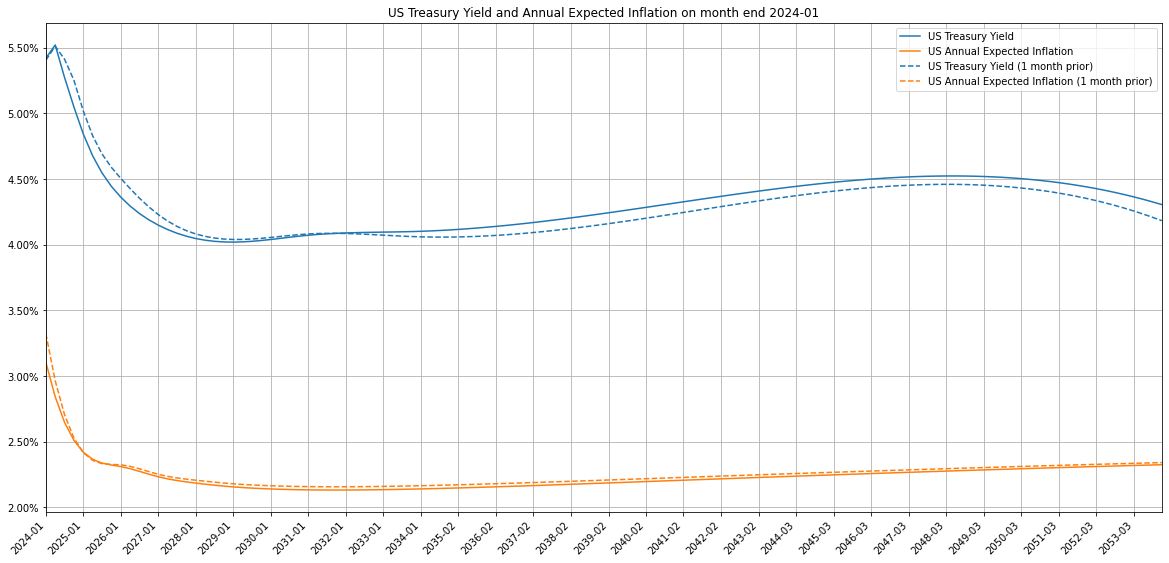

In [27]:
ax = df.iloc[:,:2].plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Expected Inflation on month end ' + date.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]), xticks=df.index[::4], xlabel='', rot=45)
df.iloc[:,2:].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df.index[::4])))

In [48]:
# Since Federal Reserve Bank of Cleveland published expected inflation for maturities of 1 year and longer,
# it's more accurate to limit the comparison from the prior month to maturities starting from 1 year to avoid
# noise from interpolation
date_from = date + relativedelta(years=1)
print('Yields changed by {:+.2f}bps\nExpected Inflation changed by {:+.2f}bps'.format(
    (df.iloc[:,0] - df.iloc[:,2]).mean()*10000,
    (df.loc[date_from:,df.columns[1]] - df.loc[date_from:,df.columns[3]]).mean()*10000))
date_split = '2027'
print('Expected Inflation for maturities till {0} changed by {1:+.2f}bps\n'
      'Expected Inflation for maturities from {0} changed by {2:+.2f}bps'.format(date_split,
    (df.loc[date_from:date_split,df.columns[1]] - df.loc[date_from:date_split,df.columns[3]]).mean()*10000,
    (df.loc[date_split:,df.columns[1]] - df.loc[date_split:,df.columns[3]]).mean()*10000))

Yields changed by +3.54bps
Expected Inflation changed by -2.01bps
Expected Inflation for maturities till 2027 changed by -1.16bps
Expected Inflation for maturities from 2027 changed by -2.11bps


In [29]:
long_term_shift_in_years = 3
print('Long-term (>{:d}y) average expected inflation: {:.2%} as of month {:%Y-%m}'.format(
    long_term_shift_in_years,
    df.loc[date + relativedelta(years=long_term_shift_in_years):,df.columns[1]].mean(),
    data_infl.index[-1].date()) )

Long-term (>3y) average expected inflation: 2.21% as of month 2024-01


In [30]:
print('Long-term (>{:d}y) average expected inflation: {:.2%} as of month {:%Y-%m}'.format(
    long_term_shift_in_years,
    df.loc[date + relativedelta(years=long_term_shift_in_years):,df.columns[3]].mean(),
    data_infl.index[-2].date()) )

Long-term (>3y) average expected inflation: 2.23% as of month 2023-12


In [31]:
data_infl

,Annual seasonaly adjusted CPI,EXPINF1YR,EXPINF2YR,EXPINF3YR,EXPINF4YR,EXPINF5YR,EXPINF6YR,EXPINF7YR,EXPINF8YR,EXPINF9YR,...,EXPINF21YR,EXPINF22YR,EXPINF23YR,EXPINF24YR,EXPINF25YR,EXPINF26YR,EXPINF27YR,EXPINF28YR,EXPINF29YR,EXPINF30YR
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,3.0088%,1.5014%,1.4006%,1.3816%,1.3884%,1.4068%,1.4311%,1.4583%,1.4871%,1.5165%,...,1.8276%,1.8486%,1.8688%,1.8884%,1.9073%,1.9255%,1.9431%,1.9601%,1.9765%,1.9923%
2012-02-01,2.8982%,1.3621%,1.3572%,1.3729%,1.3971%,1.4255%,1.4560%,1.4872%,1.5186%,1.5497%,...,1.8597%,1.8801%,1.8998%,1.9188%,1.9371%,1.9548%,1.9718%,1.9883%,2.0041%,2.0194%
2012-03-01,2.5829%,1.6869%,1.5452%,1.5135%,1.5139%,1.5277%,1.5480%,1.5717%,1.5972%,1.6233%,...,1.9046%,1.9236%,1.9420%,1.9598%,1.9769%,1.9935%,2.0095%,2.0250%,2.0399%,2.0543%
2012-04-01,2.2732%,1.5903%,1.4564%,1.4213%,1.4185%,1.4304%,1.4500%,1.4739%,1.5001%,1.5275%,...,1.8304%,1.8512%,1.8712%,1.8906%,1.9093%,1.9274%,1.9449%,1.9617%,1.9780%,1.9938%
2012-05-01,1.7379%,0.7893%,1.0055%,1.0950%,1.1557%,1.2066%,1.2530%,1.2966%,1.3380%,1.3776%,...,1.7464%,1.7700%,1.7926%,1.8145%,1.8355%,1.8558%,1.8753%,1.8942%,1.9123%,1.9298%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,3.6941%,2.7696%,2.6037%,2.5086%,2.4499%,2.4129%,2.3897%,2.3756%,2.3675%,2.3636%,...,2.4118%,2.4174%,2.4229%,2.4283%,2.4336%,2.4388%,2.4440%,2.4489%,2.4538%,2.4586%
2023-10-01,3.2458%,2.7912%,2.6242%,2.5300%,2.4719%,2.4352%,2.4121%,2.3979%,2.3896%,2.3855%,...,2.4286%,2.4337%,2.4389%,2.4439%,2.4489%,2.4538%,2.4586%,2.4632%,2.4678%,2.4722%
2023-11-01,3.1395%,3.0917%,2.6996%,2.5232%,2.4241%,2.3640%,2.3265%,2.3033%,2.2893%,2.2817%,...,2.3338%,2.3407%,2.3476%,2.3545%,2.3612%,2.3678%,2.3743%,2.3806%,2.3868%,2.3928%


##### Visualizing current  US Treasury Yield and US Breakeven Inflation Curves

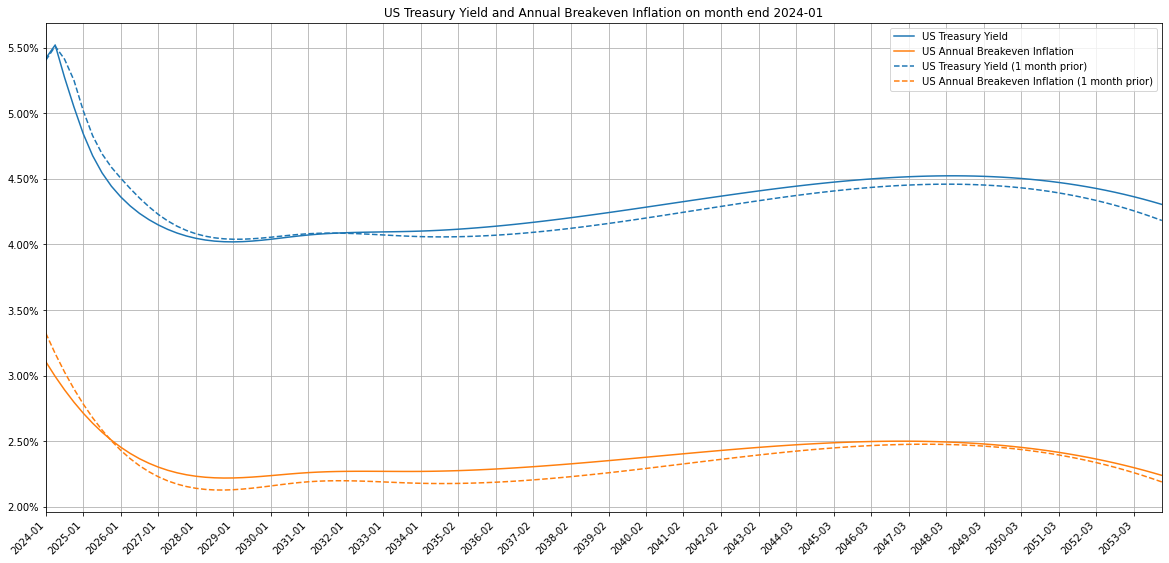

In [32]:
ax = df_brk_evn.iloc[:,:2].plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Breakeven Inflation on month end ' + date.strftime('%Y-%m'),
             xlim=(df_brk_evn.index[0], df_brk_evn.index[-1]), xticks=df_brk_evn.index[::4], xlabel='', rot=45)
df_brk_evn.iloc[:,2:].plot(ax=ax, grid=True, xticks=df_brk_evn.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df_brk_evn.index[::4])))

In [33]:
print('Yield curve changed by {:.2f}bp'.format((df_brk_evn.iloc[:,0] - df_brk_evn.iloc[:,2]).abs().mean()*10000))

# Since FRED only published breakeven inflation for maturities of 5 years and longer, it's more accurate to limit
# the comparison from the prior month to maturities starting from 5 years to avoid noise from interpolation
date_from = date + relativedelta(years=5)
print('Breakeven Inflation changed by {:.2f}bp'.format((df_brk_evn.loc[date_from:,df_brk_evn.columns[1]]
                                                        - df_brk_evn.loc[date_from:,df_brk_evn.columns[3]]).mean()*10000))

Yield curve changed by 6.79bp
Breakeven Inflation changed by 6.09bp


In [34]:
print('Yield curve changed by {:.2f}bp'.format((df_brk_evn.loc[:'2025-06',df_brk_evn.columns[0]]
                                                - df_brk_evn.loc[:'2025-06',df_brk_evn.columns[2]]).mean()*10000))
print('Yield curve changed by {:.2f}bp'.format((df_brk_evn.loc['2025-06':,df_brk_evn.columns[0]]
                                                - df_brk_evn.loc['2025-06':,df_brk_evn.columns[2]]).mean()*10000))

Yield curve changed by -10.77bp
Yield curve changed by 4.30bp


#### Visualizing US Treasury Yield and US Expected Inflation Curves as of 1, 2, and 5 years ago 

In [35]:
curve_points_1_year_ago = curve_1_year_ago.get_curve_points(120)
curve_points_infl_1_year_ago = curve_infl_1_year_ago.get_curve_points(120)
curve_points_1_year_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_1_year_ago.rename('US Annual Expected Inflation', inplace=True)
df_1_year_ago = pd.concat([curve_points_1_year_ago, curve_points_infl_1_year_ago], axis=1)

In [36]:
curve_points_2_years_ago = curve_2_years_ago.get_curve_points(120)
curve_points_infl_2_years_ago = curve_infl_2_years_ago.get_curve_points(120)
curve_points_2_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_2_years_ago.rename('US Annual Expected Inflation', inplace=True)
df_2_years_ago = pd.concat([curve_points_2_years_ago, curve_points_infl_2_years_ago], axis=1)

In [37]:
curve_points_5_years_ago = curve_5_years_ago.get_curve_points(120)
curve_points_infl_5_years_ago = curve_infl_5_years_ago.get_curve_points(120)
curve_points_5_years_ago.rename('US Treasury Yield', inplace=True)
curve_points_infl_5_years_ago.rename('US Annual Expected Inflation', inplace=True)
df_5_years_ago = pd.concat([curve_points_5_years_ago, curve_points_infl_5_years_ago], axis=1)

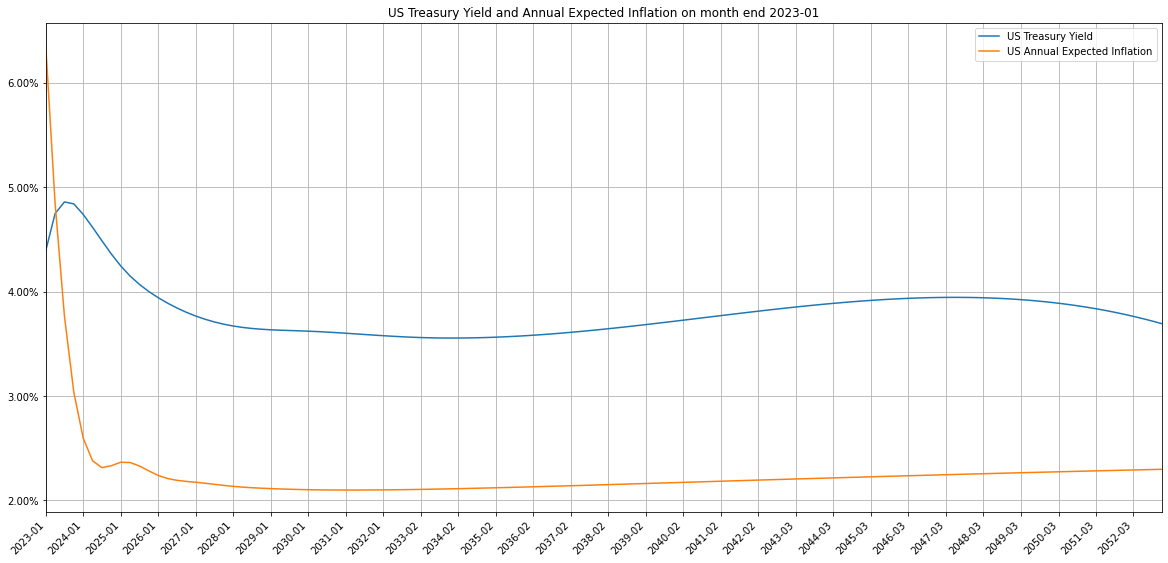

In [38]:
ax = df_1_year_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Expected Inflation on month end ' + date_1_year_ago.strftime('%Y-%m'),
             xlim=(df_1_year_ago.index[0], df_1_year_ago.index[-1]),
             xticks=df_1_year_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df_1_year_ago.index[::4])))

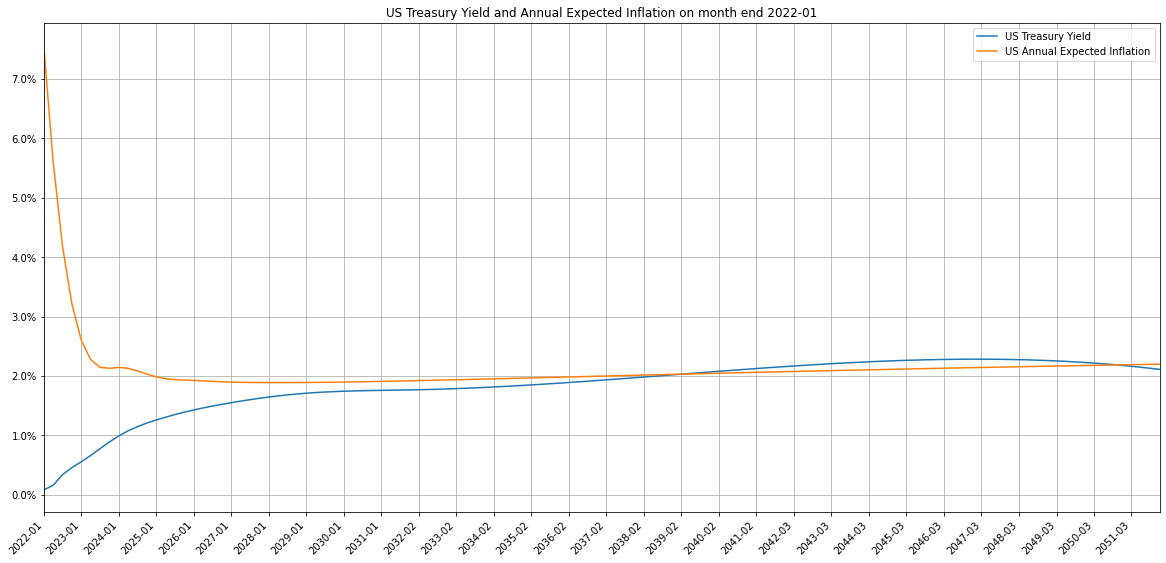

In [39]:
ax = df_2_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Expected Inflation on month end ' + date_2_years_ago.strftime('%Y-%m'),
             xlim=(df_2_years_ago.index[0], df_2_years_ago.index[-1]),
             xticks=df_2_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df_2_years_ago.index[::4])))

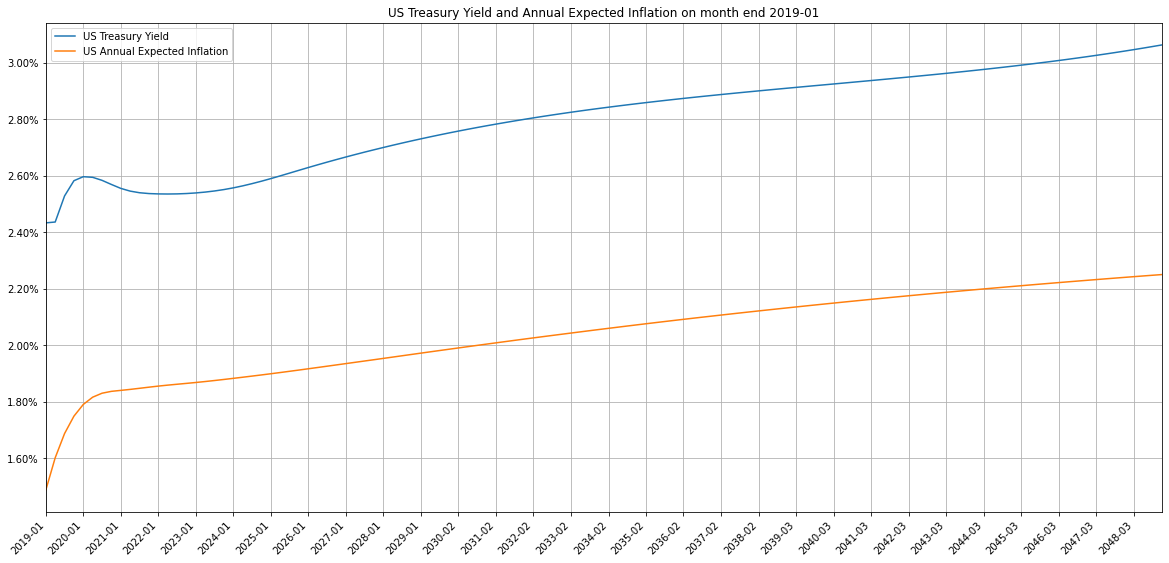

In [40]:
ax = df_5_years_ago.plot(figsize=(20,10), grid=True,
             title='US Treasury Yield and Annual Expected Inflation on month end ' + date_5_years_ago.strftime('%Y-%m'),
             xlim=(df_5_years_ago.index[0], df_5_years_ago.index[-1]),
             xticks=df_5_years_ago.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, df_5_years_ago.index[::4])))

### Correlations changes in the Fed Funds Effective Rate and CPI
It's interesting to look at how tighter monetary policy as expressed by the Federal Funds Effective Rate correlates with CPI. Since such dependencies play out over a few quarters, I downsample to quarterly frequencies.

* **Fed Funds Effective Rate and CPI**: No immediate sizable correlation, however it becomes noticable after 2 years &mdash; i.e. Fed Funds Rate increases in a given quarter correlate negatively with CPI in about 2 years. Still, the correlation is rather small &mdash; about -8% over the entire time period of 1955-2022 and about -13% when I analyze the periods with bouts of high inflation 1955-1985. Nevertheless, the correlation between changes in the broad money supply M2 and CPI is much stronger &asymp; 55%, as you can see in [this notebook](./M2_PCE_and_CPI.ipynb).

In [41]:
report_start = date.fromisoformat('1954-07-01')

In [42]:
cpi_ffr = web.get_data_fred(['CPIAUCSL', 'FEDFUNDS'], report_start)

# Downsample to quarter start based on the value in the last month of the quarter
cpi_ffr = cpi_ffr.resample('QS').last()

# Convert to annual percentage changes
cpi_ffr.update(cpi_ffr.pct_change())

cpi_ffr = cpi_ffr['1955':]

Very small positive immediate correlation.

In [43]:
cpi_ffr.corr()

,CPIAUCSL,FEDFUNDS
CPIAUCSL,100.0000%,18.5519%
FEDFUNDS,18.5519%,100.0000%


Let's see how it changes as we look at correlation between tightening of the Fed Funds Rate and CPI in a few quarters later.

In [44]:
ffr = cpi_ffr.FEDFUNDS
cpi = cpi_ffr.CPIAUCSL

GRAPH_TITLE = 'Correlation between changes in Fed Funds Effective Rate and CPI over '

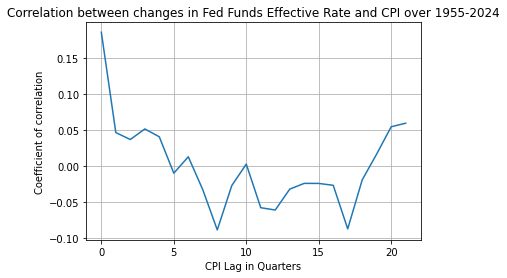

In [45]:
idx = pd.Index(range(22), name='CPI Lag in Quarters')
effect_of_monetary_tightning = pd.Series(idx.map(lambda lag: ffr.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_monetary_tightning.plot(grid=True, title=GRAPH_TITLE + '%d-%d' % (ffr.index[0].year, ffr.index[-1].year),
                                      ylabel='Coefficient of correlation')

Indeed, as expected, we see a negative correlation with a lag of about 2 years. However it's not very strong. Let's see if it's different if we limit the analysis to 1960-1986 period when we saw bouts of high inflation.

In [46]:
ffr_85 = cpi_ffr.FEDFUNDS[:'1986']
cpi_85 = cpi_ffr.CPIAUCSL[:'1986']

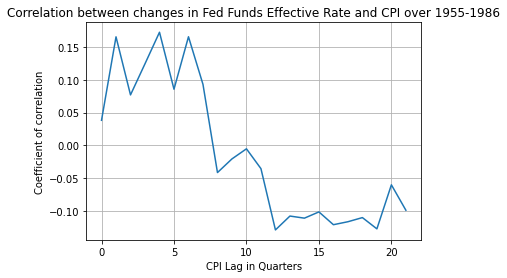

In [47]:
effect_of_monetary_tightning = pd.Series(idx.map(lambda lag: ffr_85.corr(cpi_85.shift(-lag))), index=idx)
_ = effect_of_monetary_tightning.plot(grid=True, title=GRAPH_TITLE + '%d-%d' % (ffr_85.index[0].year, ffr_85.index[-1].year),
                                      ylabel='Coefficient of correlation')

A somewhat stronger correlation of about -13% as compared to -8% when I looked at the whole series of 1955-2022. Nevertheless, the correlation between changes in the broad money supply M2 and CPI is much stronger as you can see in [this notebook](./M2_PCE_and_CPI.ipynb).